[ 0.00276754]
[ 0.00253493]
[ 0.0312284]
[ 0.00620286]
[-0.00096796]
[-0.00550329]
[-0.00227615]
[ 0.04754609]
[ 0.00821614]
[-0.00557629]
[ 0.00031565]
[('WIKI/BAC', array([ 0.00276754])), ('WIKI/F', array([ 0.00253493])), ('WIKI/MTW', array([ 0.0312284])), ('WIKI/KR', array([ 0.00620286])), ('WIKI/WMT', array([-0.00096796])), ('WIKI/WFM', array([-0.00550329])), ('WIKI/UNFI', array([-0.00227615])), ('WIKI/BA', array([ 0.04754609])), ('WIKI/GS', array([ 0.00821614])), ('WIKI/IBM', array([-0.00557629])), ('WIKI/DIS', array([ 0.00031565]))]


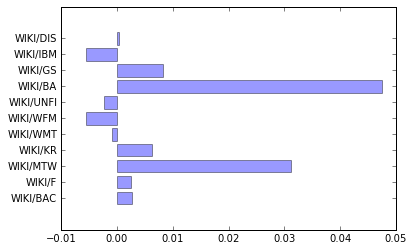

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jan 24 16:43:20 2017

@author: nandanthor
"""

import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import NuSVR


tickers = ['WIKI/BAC', 'WIKI/F', 'WIKI/MTW', 'WIKI/KR', 'WIKI/WMT', 'WIKI/WFM','WIKI/UNFI', 'WIKI/BA', 'WIKI/GS', 'WIKI/IBM', 'WIKI/DIS']

predicts = []

for i in range(len(tickers)):
    data = quandl.get(tickers[i], authtoken='TBRdSMHYKwL7HbrVKxT3', trim_start='2010-01-01', trim_end = '2017-01-25', collapse='daily')
#    data_test = quandl.get(tickers[i], authtoken='TBRdSMHYKwL7HbrVKxT3', trim_start='2017-01-25', trim_end = '2017-01-25')
#    data.append(data_test)
    price = data['Adj. Close']
    daily_ret = (price / price.shift(1))-1
    
    rm = price.rolling(center=False, window = 20).mean()
    sd = price.rolling(center=False, window = 20).std()
    df = pd.concat([price, daily_ret, rm, sd], axis = 1)
    df.columns.values[0]='Price'
    df.columns.values[1]='Daily Ret'
    df.columns.values[2]='Roll Mean'
    df.columns.values[3]='Roll Std'
    
    bb = []
    for i in range(len(df)):
        up_ran = df['Roll Mean'][i] + (2 * df['Roll Std'][i])
        low_ran = df['Roll Mean'][i] - (2 * df['Roll Std'][i])
        if df['Price'][i] >= up_ran and df['Price'][i] >= low_ran:
            bb.append(0)
        else:
            bb.append(1)
    bollb = pd.Series(bb)
    df['Boll Bonds'] = bollb.values
#    ##Assume risk-free rate is 2.4%
    sr = (df['Daily Ret'] - .024) / df['Roll Std']
    df1 = pd.concat([df, sr], axis = 1)
    df1.columns.values[5]='Sharpe Ratio'
    df2 = df1.ix[20:]
    y = df2['Daily Ret']
    X = df2.drop(['Price', 'Daily Ret'], 1)

#################################
#
    X_train = X[:-1]
    y_train = y[1:]

    X_test = X.ix[-1:]
#    print(X_test)
    clf = NuSVR()
    clf.fit(X_train,y_train)
    preds = clf.predict(X_test)
    print(preds)

    predicts.append(preds)

outs = list(zip(tickers, predicts))
print(outs)

%matplotlib inline

y_pos= np.arange(len(tickers))
plt.barh(y_pos, predicts, align='center', alpha=0.4)
plt.yticks(y_pos, tickers)
plt.show()
